✅ Predictions loaded from: data/predictions.csv
Columns in CSV: ['candidate_id', 'gender', 'ethnicity', 'education', 'years_experience', 'skills', 'label', 'skills_list', 'num_skills', 'skills_text', 'prediction']
Detected true label column: label
Detected prediction columns: {'Prediction': 'prediction'}
Detected protected columns: ['gender', 'ethnicity']
📊 Benchmark Metrics Table:


,Model,Accuracy,F1-score,DP Gap (gender),EO Gap (gender),DP Gap (ethnicity),EO Gap (ethnicity)
0,Prediction,0.433,0.0,0.0,0.0,0.0,0.0


/var/folders/0w/nbwdkbcx5ws_ty0spn4tlk1m0000gn/T/ipykernel_3351/352247923.py:109: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim(0, metrics_df[fairness_cols].max().max() * 1.2)


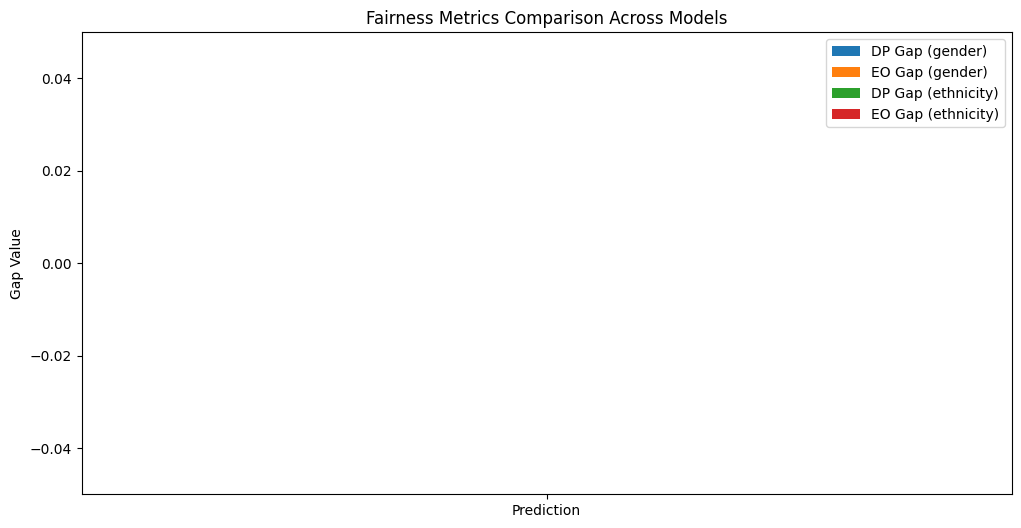

/var/folders/0w/nbwdkbcx5ws_ty0spn4tlk1m0000gn/T/ipykernel_3351/352247923.py:124: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim(0, metrics_df[metric].max()*1.5)


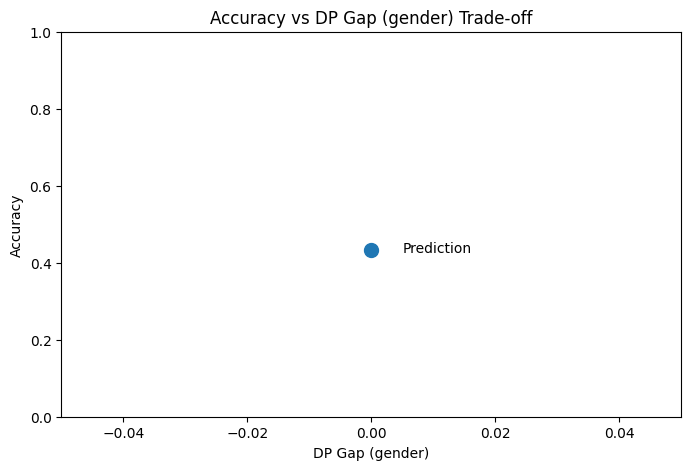

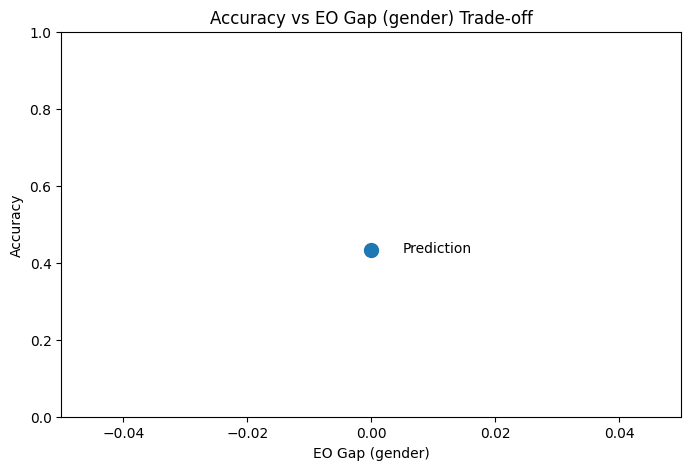

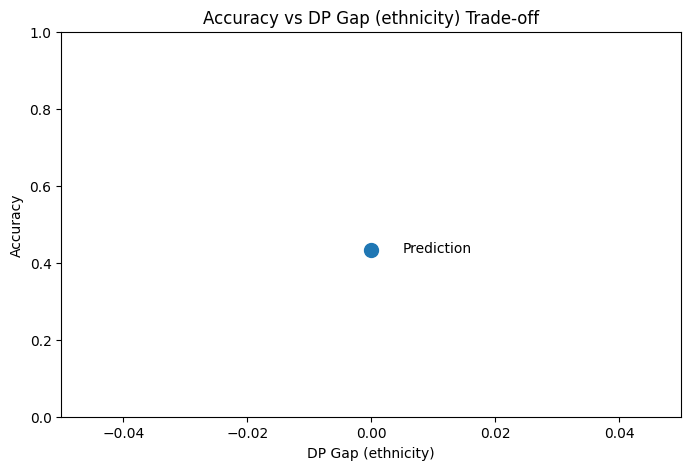

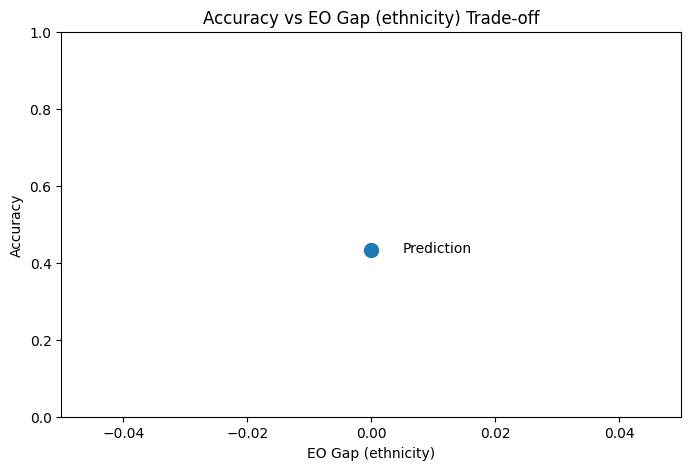

🏆 Models Ranked by Accuracy + Fairness Composite Score:


,Model,Accuracy,Composite Score,Rank
0,Prediction,0.433,0.433,1.0


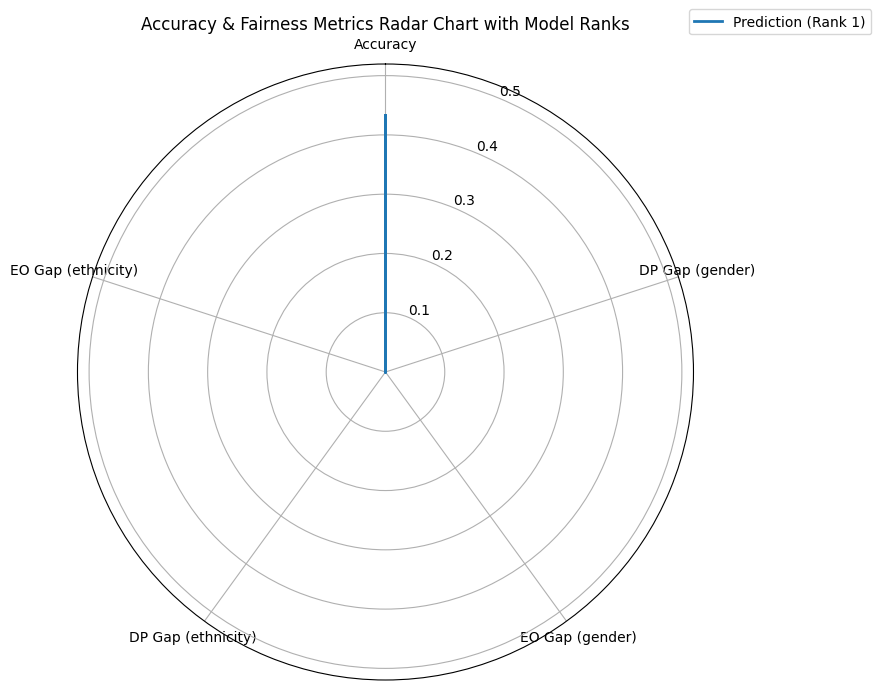

In [19]:
# ===============================================
# Day 8 – Benchmark Bias Results (Safe & Fully Functional)
# ===============================================

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score

# -----------------------------
# 1️⃣ Load predictions CSV (path-independent)
# -----------------------------
possible_paths = [
    os.path.join("notebooks", "data", "predictions.csv"),
    os.path.join("data", "predictions.csv"),
    os.path.join("predictions.csv")
]

csv_path = next((p for p in possible_paths if os.path.exists(p)), None)
if csv_path is None:
    raise FileNotFoundError(f"Predictions CSV not found in: {possible_paths}")

df = pd.read_csv(csv_path)
print(f"✅ Predictions loaded from: {csv_path}")
print("Columns in CSV:", df.columns.tolist())

# -----------------------------
# 2️⃣ Detect label and prediction columns automatically
# -----------------------------
# Detect label column: first column containing 'label'
label_col = next((c for c in df.columns if 'label' in c.lower() and 'pred' not in c.lower()), None)
if label_col is None:
    raise ValueError("No true label column found. Please check your CSV.")

# Detect prediction columns: columns containing 'pred'
pred_cols = {col.split('_')[-1].capitalize(): col for col in df.columns if 'pred' in col.lower()}
if len(pred_cols) == 0:
    raise ValueError("No prediction columns found. Please check your CSV.")

# Detect protected attributes automatically (optional: adjust as needed)
protected_cols = [c for c in df.columns if c.lower() in ['gender','ethnicity','race']]

print(f"Detected true label column: {label_col}")
print(f"Detected prediction columns: {pred_cols}")
print(f"Detected protected columns: {protected_cols}")

# -----------------------------
# 3️⃣ Define labels, predictions, protected attributes
# -----------------------------
y_true = df[label_col]
preds = {model: df[col] for model, col in pred_cols.items()}
protected_attributes = {col: df[col] for col in protected_cols}

# -----------------------------
# 4️⃣ Accuracy & F1
# -----------------------------
metrics = []
for model_name, y_pred in preds.items():
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    metrics.append({'Model': model_name, 'Accuracy': acc, 'F1-score': f1})

metrics_df = pd.DataFrame(metrics)

# -----------------------------
# 5️⃣ Fairness metric functions
# -----------------------------
def demographic_parity_gap(y_pred, group):
    groups = pd.Series(group).unique()
    rates = [(y_pred[group == g] == 1).mean() for g in groups]
    return max(rates) - min(rates)

def equal_opportunity_gap(y_true, y_pred, group):
    groups = pd.Series(group).unique()
    tpr_list = []
    for g in groups:
        mask = (group == g) & (y_true == 1)
        tpr_list.append((y_pred[mask] == 1).mean() if mask.sum() > 0 else np.nan)
    tpr_list = [x for x in tpr_list if not np.isnan(x)]
    return max(tpr_list) - min(tpr_list)

# -----------------------------
# 6️⃣ Compute fairness metrics
# -----------------------------
for model_name, y_pred in preds.items():
    for attr_name, attr_values in protected_attributes.items():
        dp_gap = demographic_parity_gap(y_pred, attr_values)
        eo_gap = equal_opportunity_gap(y_true, y_pred, attr_values)
        metrics_df.loc[metrics_df['Model'] == model_name, f'DP Gap ({attr_name})'] = dp_gap
        metrics_df.loc[metrics_df['Model'] == model_name, f'EO Gap ({attr_name})'] = eo_gap

print("📊 Benchmark Metrics Table:")
display(metrics_df)

# -----------------------------
# 7️⃣ Bar chart for fairness metrics
# -----------------------------
fairness_cols = [col for col in metrics_df.columns if 'Gap' in col]
x = np.arange(len(metrics_df['Model']))
width = 0.15

plt.figure(figsize=(12,6))
for i, col in enumerate(fairness_cols):
    plt.bar(x + i*width, metrics_df[col], width=width, label=col)
plt.xticks(x + width*(len(fairness_cols)-1)/2, metrics_df['Model'])
plt.ylabel("Gap Value")
plt.title("Fairness Metrics Comparison Across Models")
plt.ylim(0, metrics_df[fairness_cols].max().max() * 1.2)
plt.legend()
plt.show()

# -----------------------------
# 8️⃣ Accuracy vs Fairness Scatter Plots
# -----------------------------
for metric in fairness_cols:
    plt.figure(figsize=(8,5))
    for i, row in metrics_df.iterrows():
        plt.scatter(row[metric], row['Accuracy'], s=100, label=row['Model'])
        plt.text(row[metric]+0.005, row['Accuracy']-0.005, row['Model'])
    plt.xlabel(metric)
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy vs {metric} Trade-off')
    plt.xlim(0, metrics_df[metric].max()*1.5)
    plt.ylim(0,1)
    plt.show()

# -----------------------------
# 9️⃣ Composite Score & Rank
# -----------------------------
weights = {col: 1.0 for col in fairness_cols}
composite_scores = []

for i, row in metrics_df.iterrows():
    fairness_penalty = sum([row[col] * weights[col] for col in fairness_cols])
    score = row['Accuracy'] - fairness_penalty
    composite_scores.append(score)

metrics_df['Composite Score'] = composite_scores
metrics_df['Rank'] = metrics_df['Composite Score'].rank(ascending=False)
metrics_df = metrics_df.sort_values(by='Composite Score', ascending=False).reset_index(drop=True)

print("🏆 Models Ranked by Accuracy + Fairness Composite Score:")
display(metrics_df[['Model','Accuracy','Composite Score','Rank']])

# -----------------------------
# 🔟 Radar Chart
# -----------------------------
metrics_to_plot = ['Accuracy'] + fairness_cols
num_vars = len(metrics_to_plot)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

plt.figure(figsize=(8,8))
ax = plt.subplot(111, polar=True)

for i, row in metrics_df.iterrows():
    values = row[metrics_to_plot].tolist()
    values += values[:1]
    ax.plot(angles, values, label=f"{row['Model']} (Rank {int(row['Rank'])})", linewidth=2)
    ax.fill(angles, values, alpha=0.15)

ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), metrics_to_plot)
ax.set_ylim(0, max(metrics_df[metrics_to_plot].max())*1.2)
plt.title('Accuracy & Fairness Metrics Radar Chart with Model Ranks')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.show()


✅ Predictions loaded from: data/predictions.csv
Columns in CSV: ['candidate_id', 'gender', 'ethnicity', 'education', 'years_experience', 'skills', 'label', 'skills_list', 'num_skills', 'skills_text', 'prediction']
Detected true label column: label
Detected prediction columns: {'Prediction': 'prediction'}
Detected protected columns: ['gender', 'ethnicity']
📊 Benchmark Metrics Table:


,Model,Accuracy,F1-score,DP Gap (gender),EO Gap (gender),DP Gap (ethnicity),EO Gap (ethnicity)
0,Prediction,0.433,0.0,0.0,0.0,0.0,0.0


✅ Metrics table saved to reports/benchmark_metrics.csv


/var/folders/0w/nbwdkbcx5ws_ty0spn4tlk1m0000gn/T/ipykernel_3351/2936288591.py:115: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim(0, metrics_df[fairness_cols].max().max() * 1.2)


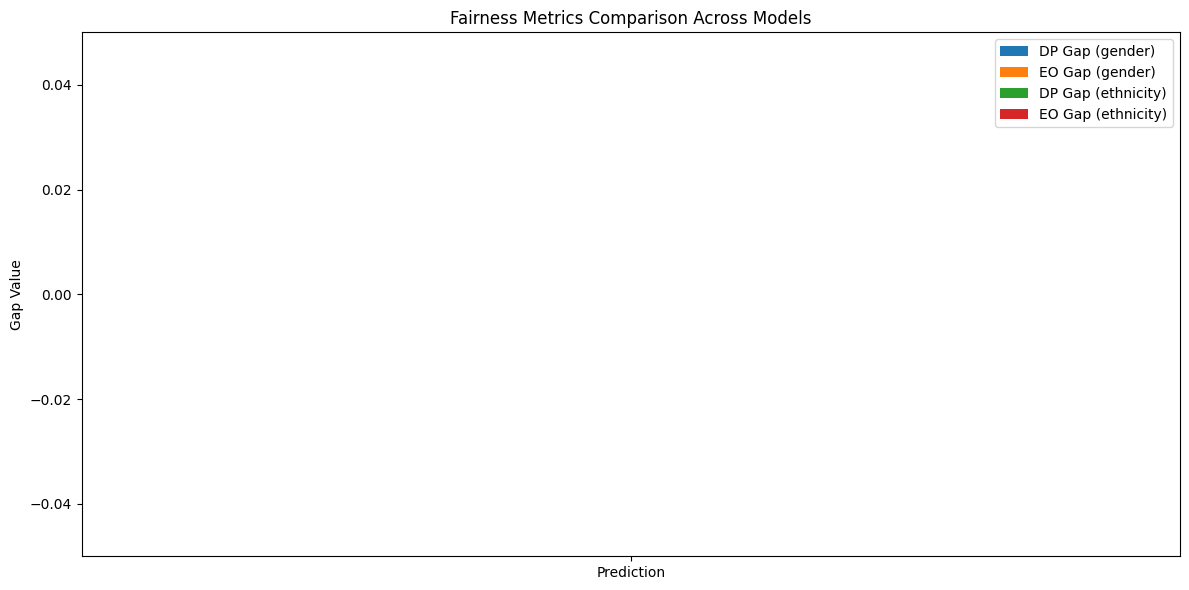

✅ Fairness bar chart saved to reports/fairness_barplot.png


/var/folders/0w/nbwdkbcx5ws_ty0spn4tlk1m0000gn/T/ipykernel_3351/2936288591.py:133: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim(0, metrics_df[metric].max()*1.5)


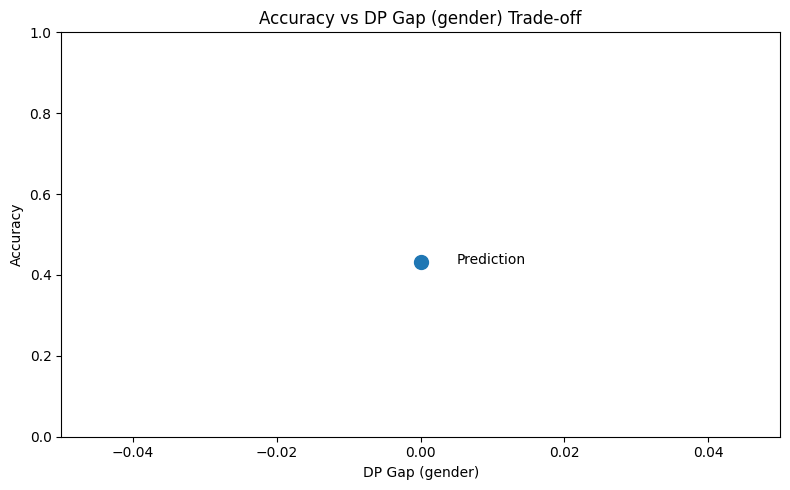

✅ Scatter plot saved to reports/accuracy_vs_DP_Gap_(gender).png


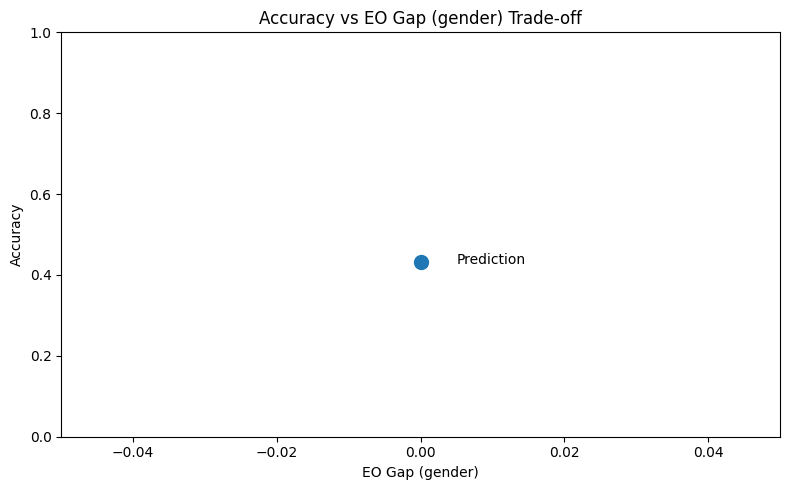

✅ Scatter plot saved to reports/accuracy_vs_EO_Gap_(gender).png


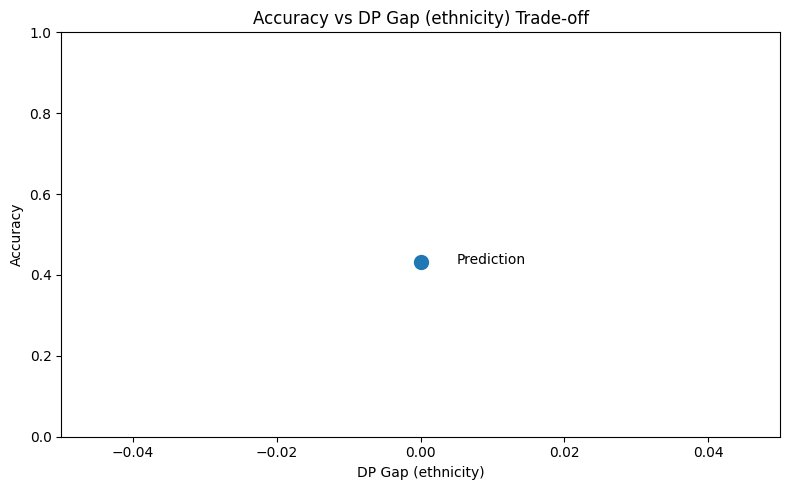

✅ Scatter plot saved to reports/accuracy_vs_DP_Gap_(ethnicity).png


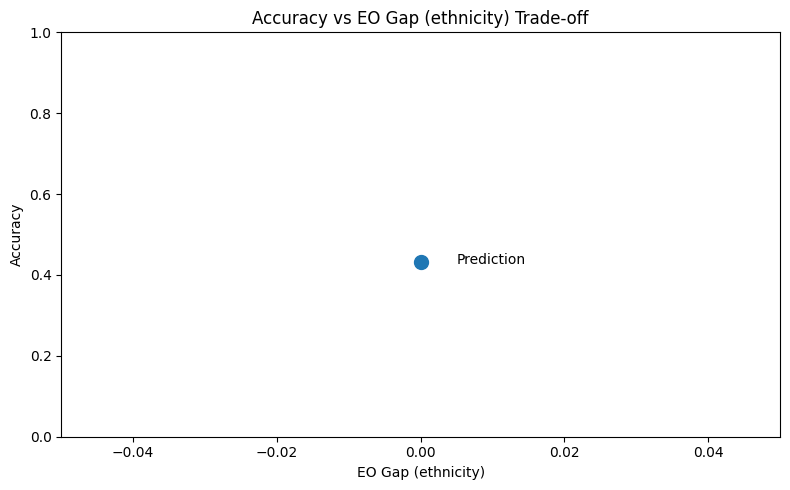

✅ Scatter plot saved to reports/accuracy_vs_EO_Gap_(ethnicity).png
🏆 Models Ranked by Accuracy + Fairness Composite Score:


,Model,Accuracy,Composite Score,Rank
0,Prediction,0.433,0.433,1.0


✅ Ranked metrics table saved to reports/benchmark_metrics_ranked.csv


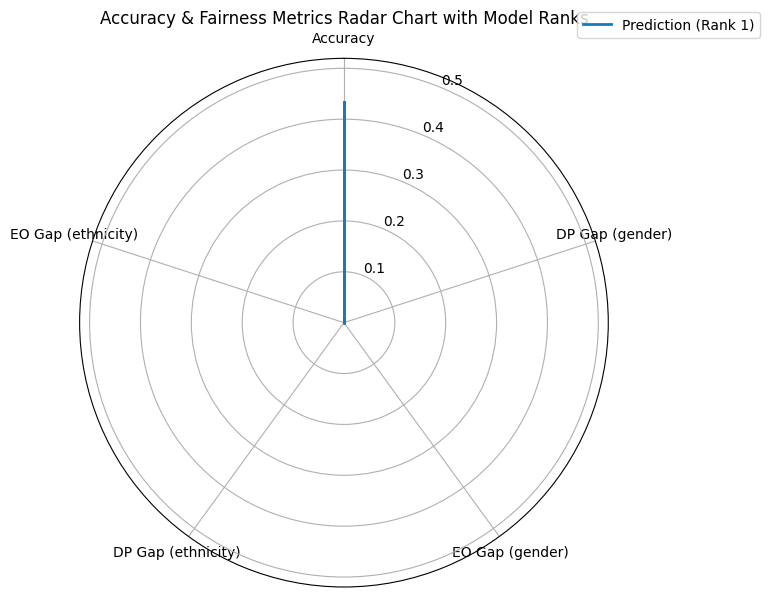

✅ Radar chart saved to reports/radar_chart.png


In [20]:
# ===============================================
# Day 8 – Benchmark Bias Results (Fully Functional & Submission-Ready)
# ===============================================

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score

# -----------------------------
# Create reports folder if not exists
# -----------------------------
os.makedirs("reports", exist_ok=True)

# -----------------------------
# 1️⃣ Load predictions CSV (path-independent)
# -----------------------------
possible_paths = [
    os.path.join("notebooks", "data", "predictions.csv"),
    os.path.join("data", "predictions.csv"),
    os.path.join("predictions.csv")
]

csv_path = next((p for p in possible_paths if os.path.exists(p)), None)
if csv_path is None:
    raise FileNotFoundError(f"Predictions CSV not found in: {possible_paths}")

df = pd.read_csv(csv_path)
print(f"✅ Predictions loaded from: {csv_path}")
print("Columns in CSV:", df.columns.tolist())

# -----------------------------
# 2️⃣ Detect label and prediction columns automatically
# -----------------------------
label_col = next((c for c in df.columns if 'label' in c.lower() and 'pred' not in c.lower()), None)
if label_col is None:
    raise ValueError("No true label column found. Please check your CSV.")

pred_cols = {col.split('_')[-1].capitalize(): col for col in df.columns if 'pred' in col.lower()}
if len(pred_cols) == 0:
    raise ValueError("No prediction columns found. Please check your CSV.")

protected_cols = [c for c in df.columns if c.lower() in ['gender','ethnicity','race']]

print(f"Detected true label column: {label_col}")
print(f"Detected prediction columns: {pred_cols}")
print(f"Detected protected columns: {protected_cols}")

# -----------------------------
# 3️⃣ Define labels, predictions, protected attributes
# -----------------------------
y_true = df[label_col]
preds = {model: df[col] for model, col in pred_cols.items()}
protected_attributes = {col: df[col] for col in protected_cols}

# -----------------------------
# 4️⃣ Accuracy & F1
# -----------------------------
metrics = []
for model_name, y_pred in preds.items():
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    metrics.append({'Model': model_name, 'Accuracy': acc, 'F1-score': f1})

metrics_df = pd.DataFrame(metrics)

# -----------------------------
# 5️⃣ Fairness metric functions
# -----------------------------
def demographic_parity_gap(y_pred, group):
    groups = pd.Series(group).unique()
    rates = [(y_pred[group == g] == 1).mean() for g in groups]
    return max(rates) - min(rates)

def equal_opportunity_gap(y_true, y_pred, group):
    groups = pd.Series(group).unique()
    tpr_list = []
    for g in groups:
        mask = (group == g) & (y_true == 1)
        tpr_list.append((y_pred[mask] == 1).mean() if mask.sum() > 0 else np.nan)
    tpr_list = [x for x in tpr_list if not np.isnan(x)]
    return max(tpr_list) - min(tpr_list)

# -----------------------------
# 6️⃣ Compute fairness metrics
# -----------------------------
for model_name, y_pred in preds.items():
    for attr_name, attr_values in protected_attributes.items():
        dp_gap = demographic_parity_gap(y_pred, attr_values)
        eo_gap = equal_opportunity_gap(y_true, y_pred, attr_values)
        metrics_df.loc[metrics_df['Model'] == model_name, f'DP Gap ({attr_name})'] = dp_gap
        metrics_df.loc[metrics_df['Model'] == model_name, f'EO Gap ({attr_name})'] = eo_gap

print("📊 Benchmark Metrics Table:")
display(metrics_df)

# Save metrics table
metrics_df.to_csv("reports/benchmark_metrics.csv", index=False)
print("✅ Metrics table saved to reports/benchmark_metrics.csv")

# -----------------------------
# 7️⃣ Bar chart for fairness metrics
# -----------------------------
fairness_cols = [col for col in metrics_df.columns if 'Gap' in col]
x = np.arange(len(metrics_df['Model']))
width = 0.15

plt.figure(figsize=(12,6))
for i, col in enumerate(fairness_cols):
    plt.bar(x + i*width, metrics_df[col], width=width, label=col)
plt.xticks(x + width*(len(fairness_cols)-1)/2, metrics_df['Model'])
plt.ylabel("Gap Value")
plt.title("Fairness Metrics Comparison Across Models")
plt.ylim(0, metrics_df[fairness_cols].max().max() * 1.2)
plt.legend()
plt.tight_layout()
plt.savefig("reports/fairness_barplot.png")
plt.show()
print("✅ Fairness bar chart saved to reports/fairness_barplot.png")

# -----------------------------
# 8️⃣ Accuracy vs Fairness Scatter Plots
# -----------------------------
for metric in fairness_cols:
    plt.figure(figsize=(8,5))
    for i, row in metrics_df.iterrows():
        plt.scatter(row[metric], row['Accuracy'], s=100, label=row['Model'])
        plt.text(row[metric]+0.005, row['Accuracy']-0.005, row['Model'])
    plt.xlabel(metric)
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy vs {metric} Trade-off')
    plt.xlim(0, metrics_df[metric].max()*1.5)
    plt.ylim(0,1)
    plt.tight_layout()
    plt.savefig(f"reports/accuracy_vs_{metric.replace(' ','_')}.png")
    plt.show()
    print(f"✅ Scatter plot saved to reports/accuracy_vs_{metric.replace(' ','_')}.png")

# -----------------------------
# 9️⃣ Composite Score & Rank
# -----------------------------
weights = {col: 1.0 for col in fairness_cols}
composite_scores = []

for i, row in metrics_df.iterrows():
    fairness_penalty = sum([row[col] * weights[col] for col in fairness_cols])
    score = row['Accuracy'] - fairness_penalty
    composite_scores.append(score)

metrics_df['Composite Score'] = composite_scores
metrics_df['Rank'] = metrics_df['Composite Score'].rank(ascending=False)
metrics_df = metrics_df.sort_values(by='Composite Score', ascending=False).reset_index(drop=True)

print("🏆 Models Ranked by Accuracy + Fairness Composite Score:")
display(metrics_df[['Model','Accuracy','Composite Score','Rank']])
metrics_df.to_csv("reports/benchmark_metrics_ranked.csv", index=False)
print("✅ Ranked metrics table saved to reports/benchmark_metrics_ranked.csv")

# -----------------------------
# 🔟 Radar Chart
# -----------------------------
metrics_to_plot = ['Accuracy'] + fairness_cols
num_vars = len(metrics_to_plot)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

plt.figure(figsize=(8,8))
ax = plt.subplot(111, polar=True)

for i, row in metrics_df.iterrows():
    values = row[metrics_to_plot].tolist()
    values += values[:1]
    ax.plot(angles, values, label=f"{row['Model']} (Rank {int(row['Rank'])})", linewidth=2)
    ax.fill(angles, values, alpha=0.15)

ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_thetagrids(np.degrees(angles[:-1]), metrics_to_plot)
ax.set_ylim(0, max(metrics_df[metrics_to_plot].max())*1.2)
plt.title('Accuracy & Fairness Metrics Radar Chart with Model Ranks')
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.savefig("reports/radar_chart.png")
plt.show()
print("✅ Radar chart saved to reports/radar_chart.png")
